<a href="https://colab.research.google.com/github/JianHMai/Taxi-Tips-Prediction/blob/SVR/CPE695_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [3]:
#Preprocessing the data
from dateutil import parser
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv("TaxiTrip2021Subset1.csv")

data = data.drop(columns='Trip End Timestamp')
data = data.rename(columns = {'Trip Start Timestamp' : 'time'})

data["Payment Type"] = LabelEncoder().fit_transform(data["Payment Type"])
data["Company"] = LabelEncoder().fit_transform(data["Company"])

for i in range(len(data)):
  data.at[i, "time"] = parser.parse(data.iloc[i,0]).time().hour

train = data.sample(frac=0.8)
test = data.drop(train.index).sample(frac=1.0)

In [ ]:
data.corr()

In [6]:
#Original
trainX = train[['Trip Seconds', 'Trip Miles', 'Fare']]
trainY = train['Tips']
testX = test[['Trip Seconds', 'Trip Miles', 'Fare']]
testY = test['Tips']

In [11]:
trainX = train[['Trip Miles', 'Fare', 'Trip Total', 'Pickup Centroid Longitude']]
trainY = train['Tips']
testX = test[['Trip Miles', 'Fare', 'Trip Total', 'Pickup Centroid Longitude']]
testY = test['Tips']

In [12]:
svr_clf = make_pipeline(StandardScaler(), SVR())
svr_clf.fit(trainX, trainY)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())])

In [13]:
svr_predY = svr_clf.predict(testX)
result = pd.DataFrame({"Fare": testX['Fare'], "Y Tips": testY, "Predicted": np.round(svr_predY,2)})
result

,Fare,Y Tips,Predicted
6492,10.00,0.00,2.12
519,20.75,0.00,0.09
7522,23.50,0.00,-0.02
3656,38.75,8.65,8.07
4433,18.50,0.00,0.10
...,...,...,...
5504,3.25,0.00,4.31
2900,45.50,0.00,0.27
2368,23.25,0.00,-0.03
5077,31.00,0.00,0.04


In [14]:
rmse = mean_squared_error(testY, svr_predY, squared=False)
print("RMSE: " + "{:.2f}".format(rmse))

RMSE: 1.23


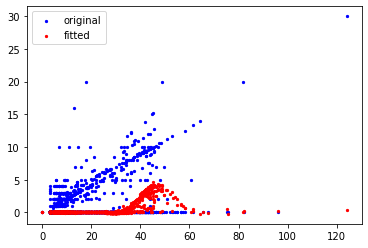

In [7]:
plt.scatter(testX['Fare'], testY, s=5, color="blue", label="original")
plt.scatter(testX['Fare'], svr_predY, s=5, color="red", label="fitted")
plt.legend()
plt.show()

In [15]:
#feature selection
from functools import partial
from sklearn.feature_selection import SelectKBest, mutual_info_regression

ftrainX = train.loc[:, data.columns != 'Tips']
ftrainY = train['Tips']

select = SelectKBest(mutual_info_regression, k=4).fit(ftrainX, ftrainY)
cols = select.get_support(indices=True)

ftrainX = ftrainX.iloc[:, cols]
ftestX = test.loc[:, data.columns != 'Tips'].iloc[:, cols]
ftestY = test['Tips']

In [16]:
ftrainX

,Trip Miles,Fare,Trip Total,Payment Type
5359,1.40,8.00,8.00,0
4802,11.11,32.50,32.50,5
2846,0.00,27.00,27.00,6
5877,18.76,43.02,43.02,0
7554,1.40,7.50,7.50,0
...,...,...,...,...
1707,0.00,8.00,12.00,1
7895,8.52,23.25,23.25,0
1618,1.64,7.50,7.50,0
3069,4.33,14.00,14.00,0


In [17]:
fsvr_clf = make_pipeline(StandardScaler(), SVR())
fsvr_clf.fit(ftrainX, ftrainY)

fsvr_predY = fsvr_clf.predict(ftestX)
result = pd.DataFrame({"Fare": ftestX['Fare'], "Y Tips": ftestY, "Predicted": np.round(fsvr_predY,2)})
result

,Fare,Y Tips,Predicted
6492,10.00,0.00,0.66
519,20.75,0.00,-0.10
7522,23.50,0.00,-0.07
3656,38.75,8.65,8.40
4433,18.50,0.00,-0.10
...,...,...,...
5504,3.25,0.00,2.88
2900,45.50,0.00,1.53
2368,23.25,0.00,-0.06
5077,31.00,0.00,0.03


In [18]:
rmse = mean_squared_error(testY, fsvr_predY, squared=False)
print("RMSE: " + "{:.2f}".format(rmse))

RMSE: 1.19


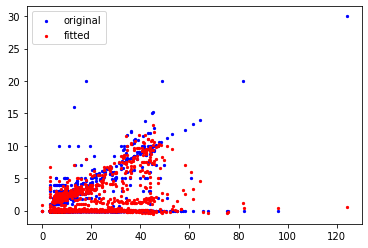

In [11]:
plt.scatter(testX['Fare'], testY, s=5, color="blue", label="original")
plt.scatter(testX['Fare'], fsvr_predY, s=5, color="red", label="fitted")
plt.legend()
plt.show()

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param = {'svr__kernel' : ['rbf', 'sigmoid'], 'svr__degree' : [2, 3], 'svr__C' : [19, 20] }

grid_clf = GridSearchCV(estimator = svr_clf, param_grid = param, scoring = 'r2')

grid_clf.fit(trainX, trainY)

for param in grid_clf.best_params_:
  print("{0}:\t{1}".format(param,grid_clf.best_params_[param]))

svr__C:	19
svr__degree:	2
svr__kernel:	rbf


In [13]:
nsvr_clf = make_pipeline(StandardScaler(), SVR(degree=2, C=20))
nsvr_clf.fit(ftrainX, ftrainY)

nsvr_predY = nsvr_clf.predict(ftestX)
result = pd.DataFrame({"Fare": ftestX['Fare'], "Y Tips": ftestY, "Predicted": np.round(nsvr_predY,2)})
result

,Fare,Y Tips,Predicted
4491,7.00,1.0,1.90
6043,5.00,0.0,-0.10
5717,5.00,0.0,-0.10
8952,5.00,0.0,-0.10
4926,3.25,0.0,-0.10
...,...,...,...
7499,8.00,0.0,-0.10
8656,8.25,0.0,-0.10
114,10.75,0.0,-0.10
5681,3.25,0.0,-0.10


In [14]:
rmse = mean_squared_error(testY, nsvr_predY, squared=False)
print("RMSE: " + "{:.2f}".format(rmse))

RMSE: 1.02


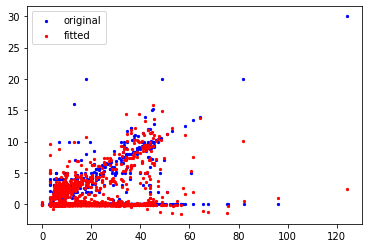

In [26]:
plt.scatter(testX['Fare'], testY, s=5, color="blue", label="original")
plt.scatter(testX['Fare'], nsvr_predY, s=5, color="red", label="fitted")
plt.legend()
plt.show()

In [25]:
result = pd.DataFrame({"Trip Fare": testX['Fare'], "Actual Tips": testY, "Original Predicted": np.round(svr_predY,2), "After feature selected": np.round(fsvr_predY,2), "After feature & parameter": np.round(nsvr_predY,2)})
result.sort_values('Actual Tips', ascending=False).head(15)

,Trip Fare,Actual Tips,Original Predicted,After feature selected,After feature & parameter
6841,124.00,30.00,0.29,0.53,2.48
376,17.75,20.00,0.08,8.03,10.70
7787,81.75,20.00,0.08,1.19,10.13
1300,48.75,20.00,0.27,8.20,14.83
8669,13.00,16.00,0.10,7.11,9.99
6477,45.25,15.22,3.92,13.24,15.89
1323,44.75,15.00,0.02,10.97,11.54
7984,64.25,13.95,-0.24,4.64,13.71
3994,41.75,13.85,2.85,11.74,13.25
3215,61.50,13.40,0.25,1.85,7.55


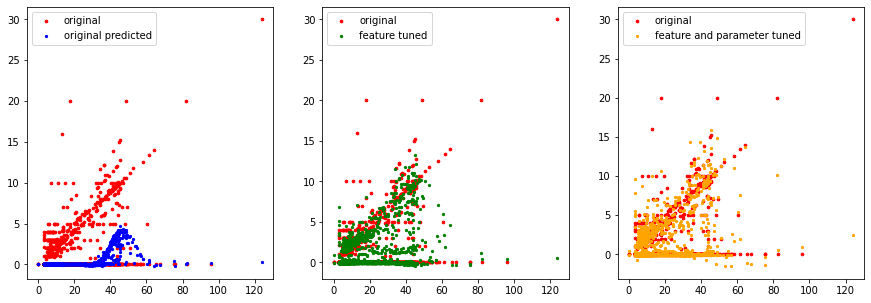

In [78]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.scatter(result['Trip Fare'], result['Actual Tips'], s=7, color="red", label="original")
plt.scatter(result['Trip Fare'], result['Original Predicted'], s=5, color="blue", label="original predicted")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(result['Trip Fare'], result['Actual Tips'], s=7, color="red", label="original")
plt.scatter(result['Trip Fare'], result['After feature selected'], s=5, color="green", label="feature tuned")
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(result['Trip Fare'], result['Actual Tips'], s=7, color="red", label="original")
plt.scatter(result['Trip Fare'], result['After feature & parameter'], s=5, color="orange", label="feature and parameter tuned")
plt.legend()

plt.show()